## Brain Tumor Detection

1. **Importing Libraries**

In [ ]:
import os
import numpy as np
import random
from PIL import Image, ImageEnhance
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Flatten, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
from sklearn.utils import shuffle

import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
from sklearn.preprocessing import label_binarize
from tensorflow.keras.models import load_model

2. **Load Dataset**

In [ ]:
train_dir = 'E:/DataScience/BrainTumorDetection/MRI Images/Training/'
test_dir = "E:/DataScience/BrainTumorDetection/MRI Images/Testing/"

# load and shuffle the train data
train_paths = []
train_labels = []

for label in os.listdir(train_dir):
    for img in os.listdir(os.path.join(train_dir, label)):
        train_paths.append(os.path.join(train_dir, label, img))
        train_labels.append(label)

train_paths, train_labels = shuffle(train_paths, train_labels)

# load and shuffle the test data
test_paths = []
test_labels = []

for label in os.listdir(test_dir):
    for img in os.listdir(os.path.join(test_dir, label)):
        test_paths.append(os.path.join(test_dir, label, img))
        test_labels.append(label)

test_paths, test_labels = shuffle(test_paths, test_labels)

3. **Data visualization**

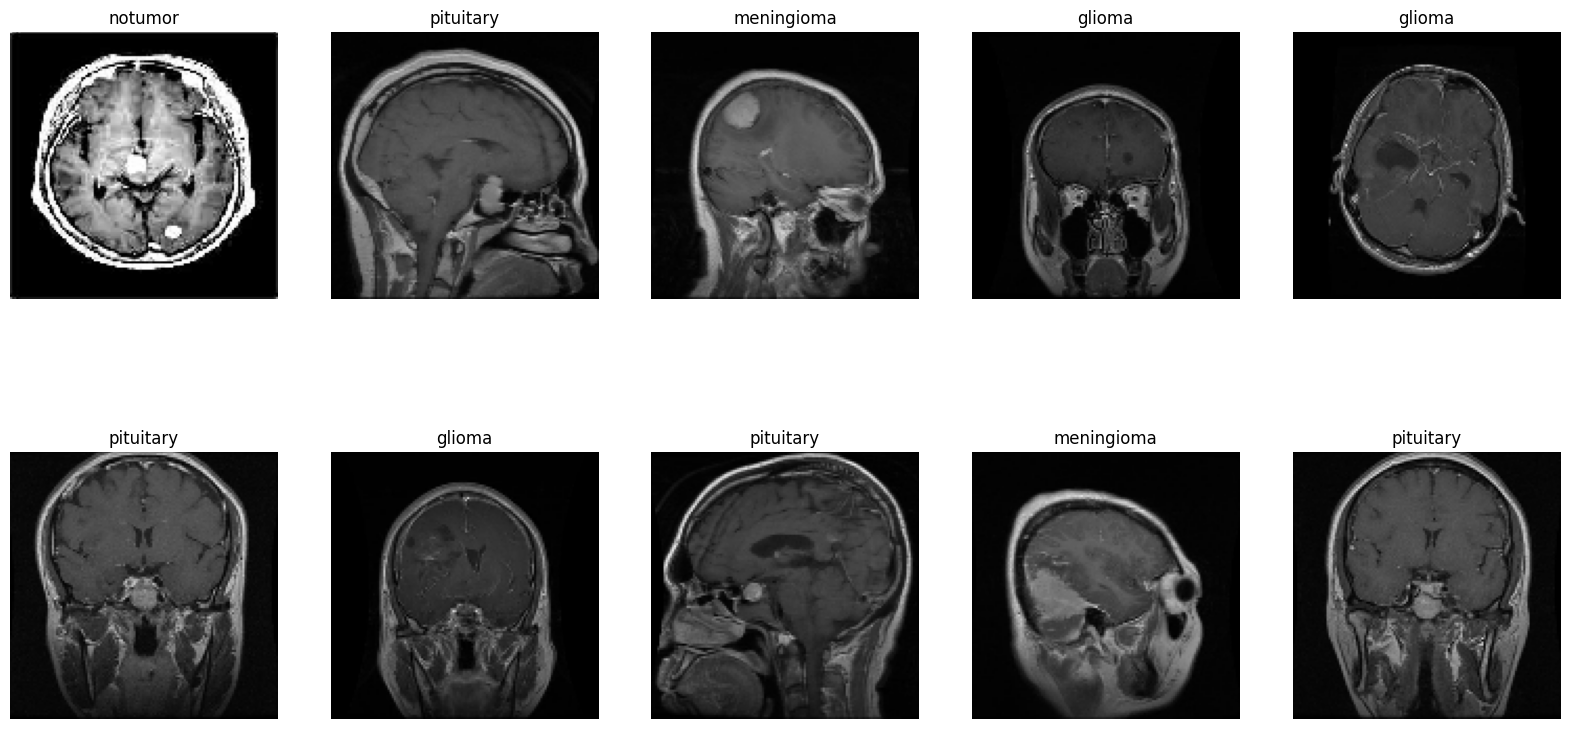

In [21]:
# lets select 10 random images from the training set
random_indices = random.sample(range(len(train_paths)), 10)
random_images = [train_paths[i] for i in random_indices]
random_labels = [train_labels[i] for i in random_indices]
# lets visualize the images
plt.figure(figsize=(20, 10))
for i, img_path in enumerate(random_images):
    plt.subplot(2, 5, i + 1)
    img = load_img(img_path, target_size=(128, 128))
    plt.imshow(img)
    plt.title(random_labels[i])
    plt.axis('off')
plt.show()

4. **Image Preprocessing**

In [ ]:
# Image Augmentation function
def augment_image(image):
    image = Image.fromarray(np.uint8(image))
    image = ImageEnhance.Brightness(image).enhance(random.uniform(0.8, 1.2))  # Random brightness
    image = ImageEnhance.Contrast(image).enhance(random.uniform(0.8, 1.2))  # Random contrast
    image = np.array(image) / 255.0  # Normalize pixel values to [0, 1]
    return image

# Load images and apply augmentation
def open_images(paths):
    images = []
    for path in paths:
        image = load_img(path, target_size=(128, 128))
        image = augment_image(image)
        images.append(image)
    return np.array(images)

# Encoding labels
def encode_label(labels):
    unique_labels = os.listdir(train_dir)  # Ensure unique labels are determined
    encoded = [unique_labels.index(label) for label in labels]
    return np.array(encoded)

# Data generator for batching
def datagen(paths, labels, batch_size=12, epochs=1):
    for _ in range(epochs):
        for i in range(0, len(paths), batch_size):
            batch_paths = paths[i:i + batch_size]
            batch_images = open_images(batch_paths)  # Open and augment images
            batch_labels = labels[i:i + batch_size]
            batch_labels = encode_label(batch_labels)  # Encode labels
            yield batch_images, batch_labels  # Yield the batch

5. **Mode Training**

In [ ]:
# Model architecture
IMAGE_SIZE = 128
base_model = VGG16(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, weights='imagenet')

# Freeze all layers of the VGG16 base model
for layer in base_model.layers:
    layer.trainable = False

# Set the last few layers of the VGG16 base model to be trainable
base_model.layers[-2].trainable = True
base_model.layers[-3].trainable = True
base_model.layers[-4].trainable = True

# Build the final model
model = Sequential()
model.add(Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
model.add(base_model)
model.add(Flatten())
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(len(os.listdir(train_dir)), activation='softmax'))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])

# Parameters
batch_size = 20
steps = int(len(train_paths) / batch_size)
epochs = 5

# Train the model
history = model.fit(datagen(train_paths, train_labels, batch_size=batch_size, epochs=epochs),
                    epochs=epochs, steps_per_epoch=steps)

Epoch 1/5
285/285 [==============================] - 387s 1s/step - loss: 0.4713 - sparse_categorical_accuracy: 0.8165
Epoch 2/5
285/285 [==============================] - 558s 2s/step - loss: 0.2303 - sparse_categorical_accuracy: 0.9174
Epoch 3/5
285/285 [==============================] - 354s 1s/step - loss: 0.1587 - sparse_categorical_accuracy: 0.9404
Epoch 4/5
285/285 [==============================] - 330s 1s/step - loss: 0.1173 - sparse_categorical_accuracy: 0.9582
Epoch 5/5
285/285 [==============================] - 268s 938ms/step - loss: 0.0786 - sparse_categorical_accuracy: 0.9708


6. **Model Training Plots**

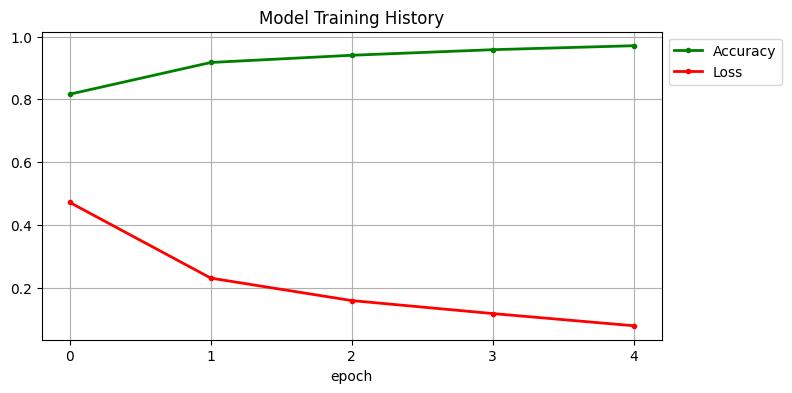

In [24]:
plt.figure(figsize=(8,4))
plt.grid(True)
plt.plot(history.history['sparse_categorical_accuracy'], '.g-', linewidth=2)
plt.plot(history.history['loss'], '.r-', linewidth=2)
plt.title('Model Training History')
plt.xlabel('epoch')
plt.xticks([x for x in range(epochs)])
plt.legend(['Accuracy', 'Loss'], loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

7. **Model Classification Report**

In [25]:
# 1. Prediction on test data
test_images = open_images(test_paths)  # Load and augment test images
test_labels_encoded = encode_label(test_labels)  # Encode the test labels

# Predict using the trained model
test_predictions = model.predict(test_images)

# 2. Classification Report
print("Classification Report:")
print(classification_report(test_labels_encoded, np.argmax(test_predictions, axis=1)))

41/41 [==============================] - 49s 1s/step
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.98      0.92       300
           1       0.96      0.80      0.87       306
           2       0.98      1.00      0.99       405
           3       0.95      0.98      0.97       300

    accuracy                           0.94      1311
   macro avg       0.94      0.94      0.94      1311
weighted avg       0.95      0.94      0.94      1311



8. **Model Confusion Plot**

Confusion Matrix:
[[293   6   0   1]
 [ 43 244   6  13]
 [  0   0 405   0]
 [  1   3   1 295]]


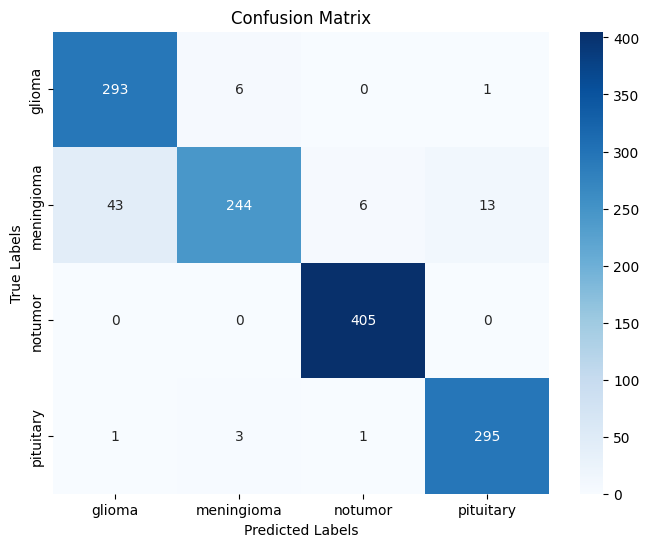

In [26]:
# 3. Confusion Matrix
conf_matrix = confusion_matrix(test_labels_encoded, np.argmax(test_predictions, axis=1))
print("Confusion Matrix:")
print(conf_matrix)

# Plot the Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=os.listdir(train_dir), yticklabels=os.listdir(train_dir))
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

9. **Roc Curve Plot**

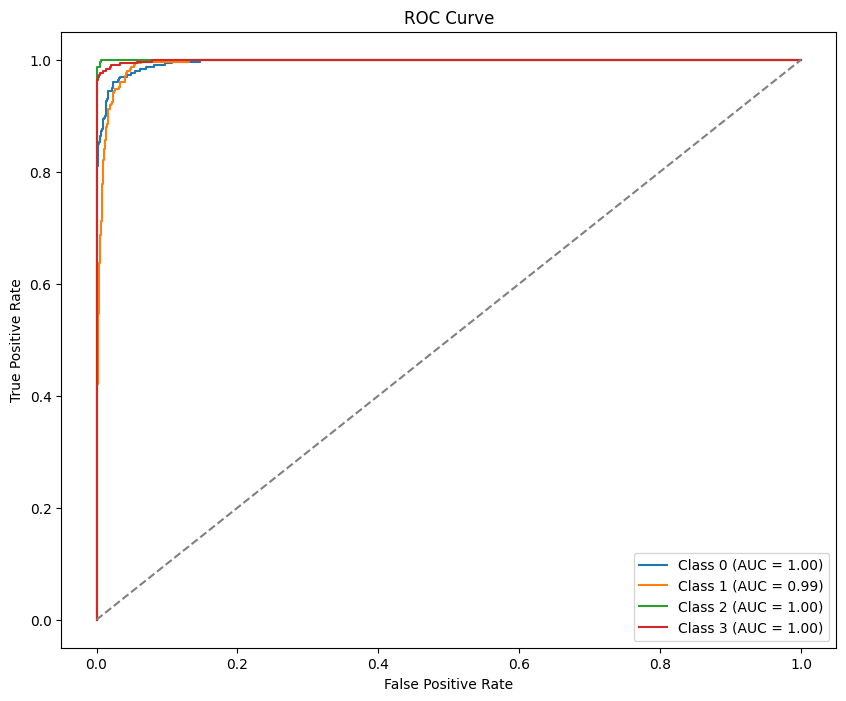

In [ ]:
test_labels_bin = label_binarize(test_labels_encoded, classes=np.arange(len(os.listdir(train_dir))))
test_predictions_bin = test_predictions  # The predicted probabilities for each class

# Compute ROC curve and ROC AUC for each class
fpr, tpr, roc_auc = {}, {}, {}
for i in range(len(os.listdir(train_dir))):
    fpr[i], tpr[i], _ = roc_curve(test_labels_bin[:, i], test_predictions_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
plt.figure(figsize=(10, 8))
for i in range(len(os.listdir(train_dir))):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Diagonal line
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()

10. **Save & Load Model**

In [28]:
# Save the entire model
model.save('btd_model.h5')

In [29]:
from tensorflow.keras.models import load_model
# Load the trained model
model = load_model('btd_model.h5')

11. **MRI Tumor Detection System**

In [31]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt

# Class labels
class_labels = ['pituitary', 'glioma', 'notumor', 'meningioma']

def detect_and_display(img_path, model, image_size=128):
    """
    Function to detect tumor and display results.
    If no tumor is detected, it displays "No Tumor".
    Otherwise, it shows the predicted tumor class and confidence.
    """
    try:
        # Load and preprocess the image
        img = load_img(img_path, target_size=(image_size, image_size))
        img_array = img_to_array(img) / 255.0  # Normalize pixel values
        img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

        # Make a prediction
        predictions = model.predict(img_array)
        predicted_class_index = np.argmax(predictions, axis=1)[0]
        confidence_score = np.max(predictions, axis=1)[0]

        # Determine the class
        if class_labels[predicted_class_index] == 'notumor':
            result = "No Tumor"
        else:
            result = f"Tumor: {class_labels[predicted_class_index]}"

        # Display the image with the prediction
        plt.imshow(load_img(img_path))
        plt.axis('off')
        plt.title(f"{result} (Confidence: {confidence_score * 100:.2f}%)")
        plt.show()

    except Exception as e:
        print("Error processing the image:", str(e))

1/1 [==============================] - 0s 316ms/step


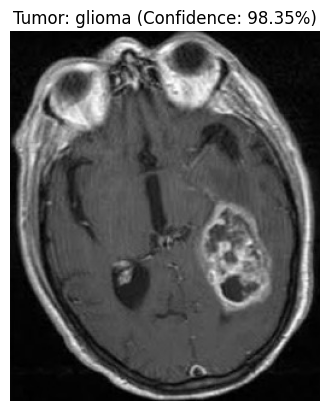

In [33]:
# Example usage
image_path = 'E:\DataScience\BrainTumorDetection\MRI Images\Testing\meningioma\Te-meTr_0001.jpg'  # Provide the path to your new image
detect_and_display(image_path, model)

1/1 [==============================] - 0s 111ms/step


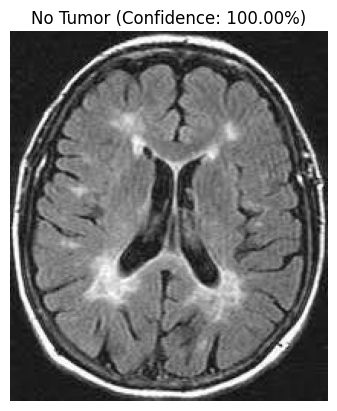

In [40]:
# Example usage
image_path = 'E:/DataScience/BrainTumorDetection/MRI Images/Testing/notumor/Te-no_0115.jpg'  # Provide the path to your new image
detect_and_display(image_path, model)

1/1 [==============================] - 0s 79ms/step


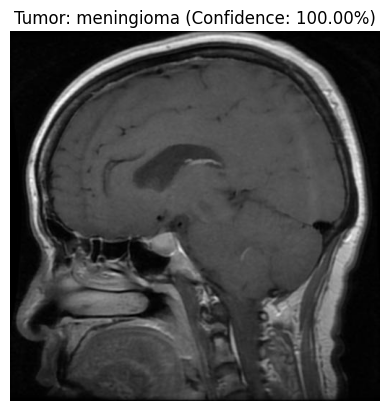

In [37]:
# Example usage
image_path = 'E:\DataScience\BrainTumorDetection\MRI Images\Testing\pituitary\Te-piTr_0003.jpg'  # Provide the path to your new image
detect_and_display(image_path, model)

1/1 [==============================] - 0s 89ms/step


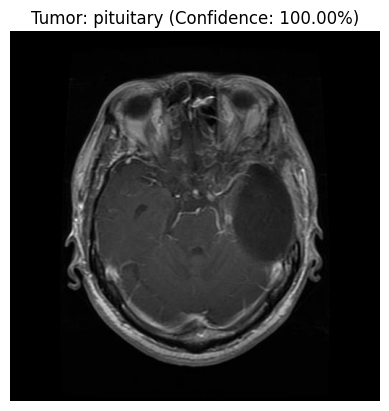

In [38]:
# Example usage
image_path = 'E:\DataScience\BrainTumorDetection\MRI Images\Testing\glioma\Te-gl_0015.jpg'  # Provide the path to your new image
detect_and_display(image_path, model)